# 案例：Fama-French三因子模型的应用

## 1.读取Fama-French三因子数据

Fama-French三因子数据来自于French在达特茅斯学院的[MBA网站](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)上。

In [1]:
import pandas as pd
df = pd.read_csv('datasets/F-F_Research_Data_Factors_weekly_CSV.csv', index_col=0)
df.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
19260702,1.60,-0.62,-0.83,0.056
19260710,0.36,-0.88,0.31,0.056
19260717,1.01,0.59,-1.44,0.056
19260724,-2.05,0.10,-0.18,0.056
19260731,3.04,-1.82,-0.90,0.056


In [2]:
df = df[['Mkt-RF', 'SMB', 'HML']]
name_dict = {'Mkt-RF':'Market Factor (MER)',
            'SMB':'Size Factor (SMB)',
            'HML':'Value Factor (HML)'}

In [3]:
df.columns = [name_dict[i] for i in df.columns]
df.index = df.index.astype(str)
df.index = pd.to_datetime(df.index, format='%Y%m%d')

In [4]:
df.head(5)

,Market Factor (MER),Size Factor (SMB),Value Factor (HML)
Date,,,
1926-07-02,1.60,-0.62,-0.83
1926-07-10,0.36,-0.88,0.31
1926-07-17,1.01,0.59,-1.44
1926-07-24,-2.05,0.10,-0.18
1926-07-31,3.04,-1.82,-0.90


## 2.读取资产数据

当我们研究投资组合，一个最佳的研究对象自然是股神巴菲特(Warren Buffett)。他在去50间实现了接近20%化收益。巴菲特师承价值投资的代表Benjamin Grahan（格雷厄姆)，非常注重股票的购买价格(安全性)。与此同时，他也逐渐发展了自己的投资格，特别是对质量的高度重视。巴菲特是否真的具有这样的投资风格?经典的多因子否可以很好地解释巴菲特的优异业绩?这些都是非常引人关注的问题。

这里我们选择其所管理的伯克希尔哈撒韦公司的股票数据，数据来源为[investing.com](https://cn.investing.com/)，并选取其日收盘价。

In [5]:
import pandas as pd
BRK = pd.read_csv('datasets/BRKa历史数据.csv', index_col=0)
BRK = BRK.sort_index()
BRK.index = pd.to_datetime(BRK.index, format='%Y-%m-%d')
BRK.head()

,收盘,开盘,高,低,交易量,涨跌幅
日期,,,,,,
2010-01-11,"99,999","100,100","100,750","99,320",1.95K,-0.30%
2010-01-12,"99,350","99,505","99,949","99,350",2.23K,-0.65%
2010-01-13,"99,150","99,400","99,949","99,150",1.02K,-0.20%
2010-01-14,"99,000","99,160","99,480","98,920",1.43K,-0.15%
2010-01-15,"97,500","99,000","99,363","97,205",2.66K,-1.52%


对数据的格式进行整理

In [6]:
import numpy as np
BRK['收盘'] = np.array([i.replace(',', '') for i in BRK['收盘']], dtype='float')

In [13]:
BRK = BRK.sort_index()

<Axes: title={'center': '伯克希尔哈撒韦公司的股价'}, xlabel='日期'>

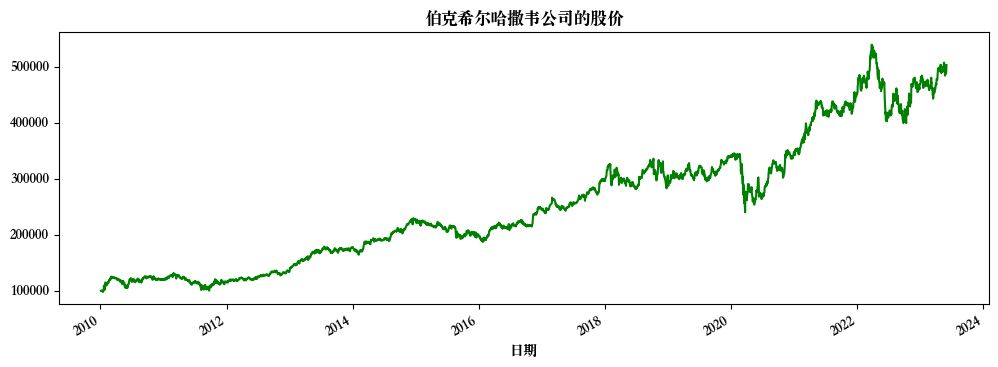

In [21]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Songti SC'
plt.rcParams['axes.unicode_minus'] = False 
BRK['收盘'].plot(figsize=(12,4), title='伯克希尔哈撒韦公司的股价', color='green')

<Axes: title={'center': '伯克希尔哈撒韦公司的股价'}, xlabel='Date'>

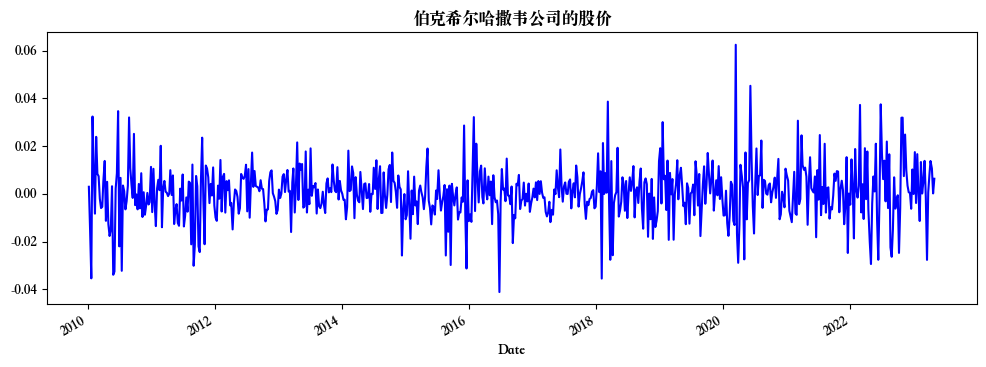

In [22]:
period = 1
df['Return'] = BRK['收盘']/BRK['收盘'].shift(period) - 1
df['Return'] = df['Return'].ffill()
df = df[df.index>pd.to_datetime('2010-01-01')]
df['Return'].plot(figsize=(12,4), title='伯克希尔哈撒韦公司的股价', color='blue')

<Axes: >

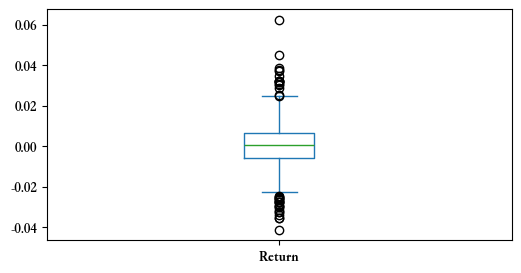

In [23]:
df['Return'].plot(kind='box', grid=False, figsize=(6,3))

剔除可能之后会影响回归模型的收益率极值，

<Axes: >

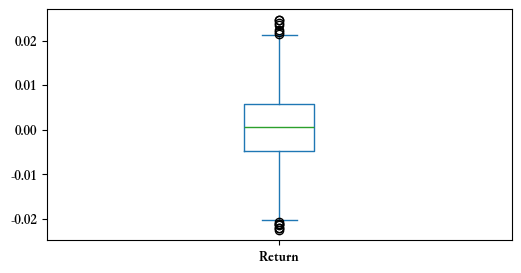

In [24]:
import numpy as np
QU = df['Return'].quantile(0.75)
QL = df['Return'].quantile(0.25)
IQR = QU - QL
df['Return'][(df['Return']>(QU + 1.5*IQR)) | (df['Return']<(QL-1.5*IQR))] = np.nan
df['Return'] = df['Return'].fillna(df['Return'].quantile(0.5))
df['Return'].plot(kind='box', grid=False, figsize=(6,3))

## 3.时序回归

我们使用seaborn来绘制变量和变量之间相关性的热力图，颜色为深色代表相关性越弱，颜色越浅代表相关性越强。接近红色，为正相关，接近蓝色，为负相关。


<Axes: >

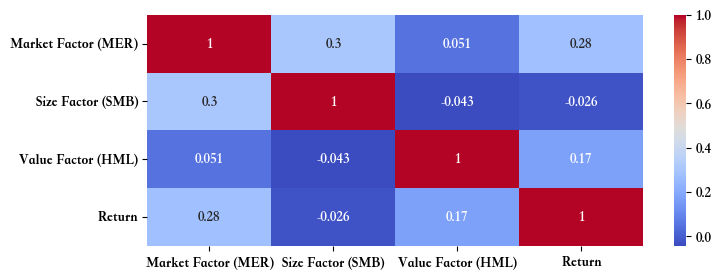

In [25]:
import seaborn as sns
plt.figure(figsize=(8,3))
sns.heatmap(df.corr(), annot = True, cmap='coolwarm')


观察上面结果，部分解释变量和解释变量之间存在很高的相关性。

当然，我们可以绘制散点图观察解释变量和被解释变量之间的相关性，同时绘制一元回归的回归线。

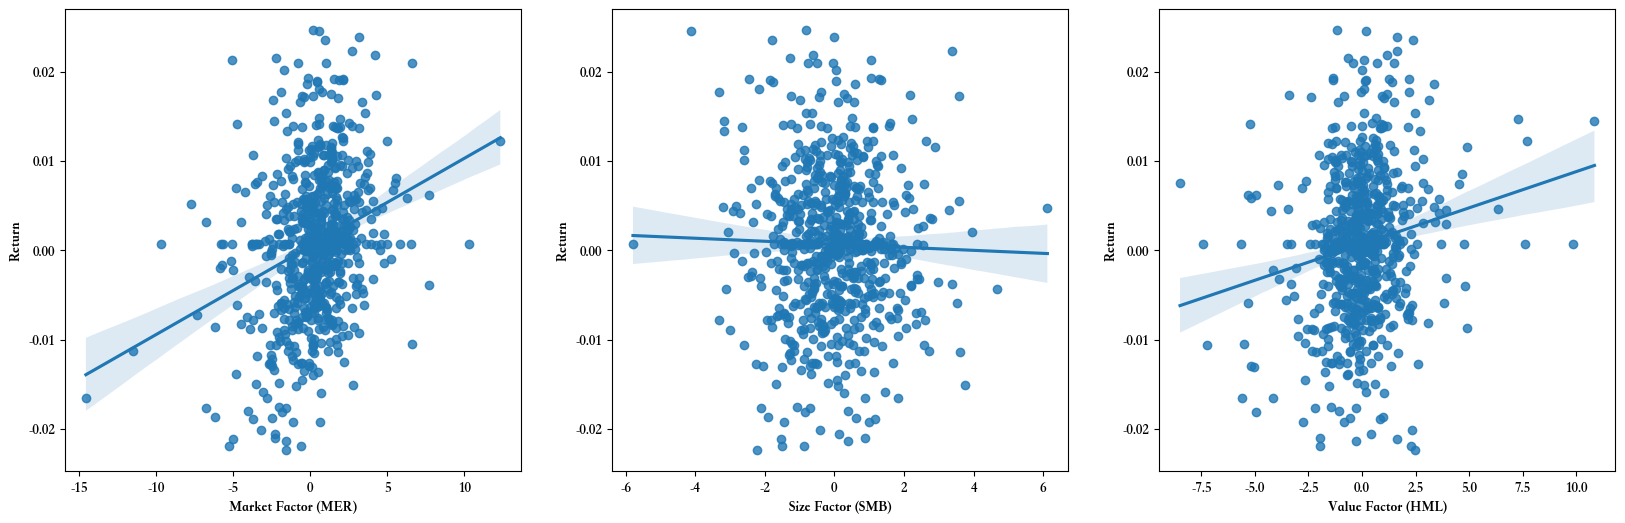

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
for i, k in enumerate(['Market Factor (MER)', 'Size Factor (SMB)', 'Value Factor (HML)']):
    sns.regplot(y=df['Return'], x=df[k], ax=axs[i])

对于解释变量（自变量）X和被解释变量（因变量）y进行OLS回归：

In [27]:
import statsmodels.api as sm
df['Intercept'] = 1.
model=sm.OLS(df['Return'],
             df[['Intercept', 'Market Factor (MER)', 'Size Factor (SMB)', 'Value Factor (HML)']])
result=model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     29.50
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           5.90e-18
Time:                        09:26:15   Log-Likelihood:                 2375.6
No. Observations:                 695   AIC:                            -4743.
Df Residuals:                     691   BIC:                            -4725.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0004      0.000      1.440      0.150      -0.000       0.001
Market Factor (MER)     0.0011      0.000      8.081      0.000       0.001       0.001
Size Factor (SMB)      -0.0007      0.000     -2.940      0.003      -0.001      -0.000
Value Factor (HML)      0.0007      0.000      4.211      0.000       0.000       0.001
==============================================================================
Omnibus:                        6.845   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.820
Skew:                           0.207   Prob(JB):                       0.0330
Kurtosis:                       3.252   Cond. No.                         2.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
beta=pd.DataFrame([result.params[0:]],
                  columns=['Market Factor (MER)', 'Size Factor (SMB)', 'Value Factor (HML)'],
                 index=['coef'])
beta

,Market Factor (MER),Size Factor (SMB),Value Factor (HML)
coef,0.001077,-0.000726,0.000716


通过上述的分析，我们看到经典的三因子模型在每个因子上的风险暴露都是统计显著的，说明三个因子每个因子都能够解释一部分收益来源。但是模型整体的$R^2$（0.114）比较低，说明三因子模型的解释力度不够，无法解释大部分收益来源。

## 4. 滑动周期回归

滑动周期回归

In [49]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
df = df.sort_values('Date')
X = df[['Market Factor (MER)', 'Size Factor (SMB)', 'Value Factor (HML)']]
y = df['Return']
X = sm.add_constant(X)
window_size = 20 #滑动周期为52周（一年）
regressions = []
for i in range(len(df) - window_size + 1):
    X_window = X.iloc[i:i+window_size]
    y_window = y.iloc[i:i+window_size]
    model = sm.OLS(y_window, X_window)
    results = model.fit()
    regressions.append(results.params[1:])  

In [50]:
X_second_step = pd.DataFrame(regressions, columns=X.columns[1:], index=df.index[window_size-1:])
y_second_step = y[window_size-1:]
X_second_step = sm.add_constant(X_second_step)
model_second_step = sm.OLS(y_second_step, X_second_step)
results_second_step = model_second_step.fit()
print(results_second_step.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.107
Date:                Sun, 21 Apr 2024   Prob (F-statistic):              0.346
Time:                        09:48:08   Log-Likelihood:                 2278.2
No. Observations:                 676   AIC:                            -4548.
Df Residuals:                     672   BIC:                            -4530.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0012    

<Axes: xlabel='Date'>

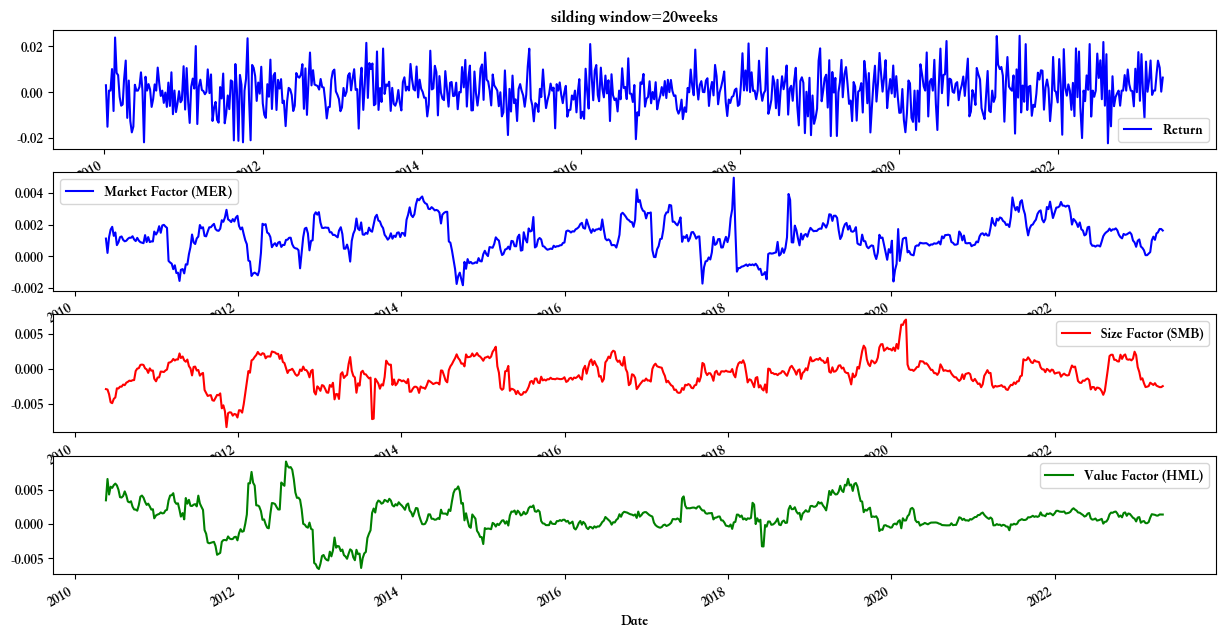

In [51]:
fig,ax = plt.subplots(nrows=4, ncols=1, figsize=(15,8))
df[['Return']].plot(ax=ax[0], color='blue', title='silding window=%sweeks' %window_size)
X_second_step[['Market Factor (MER)']].plot(ax=ax[1], color='blue')
X_second_step[['Size Factor (SMB)']].plot(ax=ax[2], color='red')
X_second_step[['Value Factor (HML)']].plot(ax=ax[3], color='green')


## 练习
请使用时序回归方法，应用五因子模型对伯克希尔哈撒韦的股价进行回归，因子数据在`datasets/F-F_Research_Data_5_Factors_XX.csv`


## 参考
1. ken.french数据库：http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
2. Fama and French, 1993, "Common Risk Factors in the Returns on Stocks and Bonds," Journal of Financial Economics